In [ ]:
from pprint import pprint
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from matplotlib import style
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans

from xgboost import plot_importance
from xgboost import plot_tree
import xgboost as xgb
from scipy.stats import uniform, randint
from xgboost.sklearn import XGBClassifier


from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch

In [ ]:
data = pd.read_excel("/content/FoodAccessResearchAtlasData2015.xlsx", sheet_name = 'Food Access Research Atlas')

In [ ]:
feature_info = pd.read_excel("/content/FoodAccessResearchAtlasData2015.xlsx", sheet_name = 'Variable Lookup')

In [ ]:
data = pd.DataFrame(data)
data.head()

,CensusTract,State,County,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,...,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP
0,1001020100,Alabama,Autauga,1,1912,693,0,0,0.000000,0,...,221,1622,217,14,0,14,45,44,26,112
1,1001020200,Alabama,Autauga,1,2170,743,0,181,0.083410,0,...,214,888,1217,5,0,5,55,75,87,202
2,1001020300,Alabama,Autauga,1,3373,1256,0,0,0.000000,0,...,439,2576,647,17,5,11,117,87,108,120
3,1001020400,Alabama,Autauga,1,4386,1722,0,0,0.000000,0,...,904,4086,193,18,4,11,74,85,19,82
4,1001020500,Alabama,Autauga,1,10766,4082,0,181,0.016812,0,...,1126,8666,1437,296,9,48,310,355,198,488


In [ ]:
#To check if any of the columns have null values
data.isnull().values.any()

False

##### Correlation Matrix

This will express the extent to which two variables are linearly related to each other. 

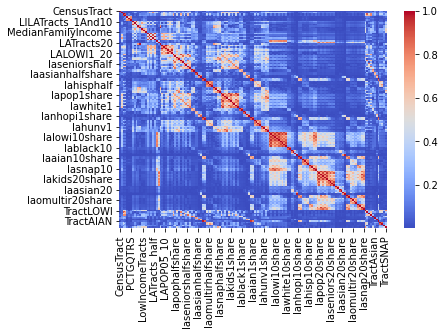

In [ ]:
correlation = data.corr(method = 'pearson').abs()
hm = sns.heatmap(correlation, cmap = 'coolwarm')

In [ ]:
#Selecting the upper triangle to drop columns with value greater than 0.95

upper = correlation.where(np.triu(np.ones(correlation.shape), k =1).astype(np.bool))
drop_related = [column for column in upper.columns if any(upper[column] > 0.95)]
print("==== The columns that have been dropped ====")
print(drop_related)

==== The columns that have been dropped ====
['LATracts1', 'LATractsVehicle_20', 'LAPOP1_20', 'LALOWI1_20', 'lakids1', 'lawhite1', 'laaian1', 'laaian1share', 'lakids10', 'lakids10share', 'lakids20', 'lakids20share', 'lanhopi20share', 'TractAIAN']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
new_data = ['State', 'CensusTract', 'Urban', 'POP2010', 'LILATracts_halfAnd10', 'HUNVFlag',
                  'LowIncomeTracts', 'PovertyRate', 'MedianFamilyIncome', 'LATracts_half',
                  'lapophalfshare', 'lalowihalfshare', 'laseniorshalfshare', 'lawhitehalfshare', 
                  'lablackhalfshare', 'laasianhalfshare', 'lanhopihalfshare', 'laaianhalfshare', 
                  'laomultirhalfshare','lahisphalfshare', 'lahunvhalfshare', 'lasnaphalfshare']
d = data[new_data].copy()

state = d['State']

#### Data Analysis

##### Population Histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f206f7a93d0>]],
      dtype=object)

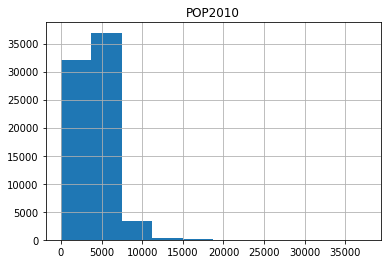

In [ ]:
d.hist(column='POP2010')

##### Flag for Urban Tract

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2068a961d0>]],
      dtype=object)

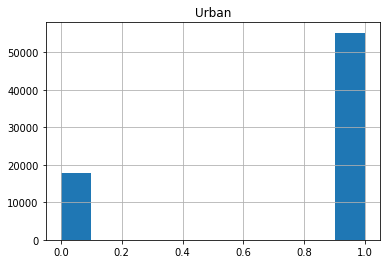

In [ ]:
d.hist(column ='Urban')

##### Polulation Tract wrt States

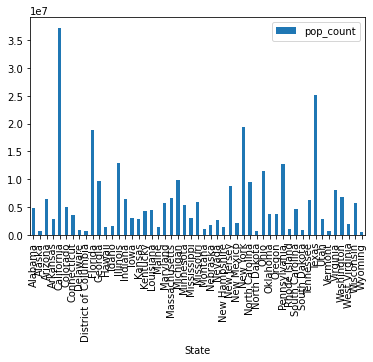

In [ ]:
pop = d[['State', 'POP2010']]
pop_tot = pop.groupby(['State']).agg(pop_count=('POP2010', 'sum'))
pop_tot.plot.bar()

##### Poverty Rate for States

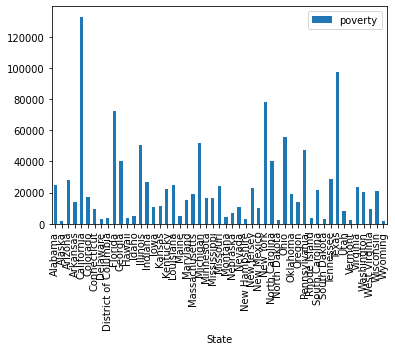

In [ ]:
pr = d[['State', 'PovertyRate']]
pr_tot = pr.groupby(['State']).agg(poverty=('PovertyRate', 'sum'))
pr_tot.plot.bar()

In [ ]:
#Exploratory data analysis 1.check for categorical columns 
d.info()

#2. Check for any null values in the data set
print(d.isnull().values.sum())

#3. Check frequency distrubution among the cat col
print(d['State'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72864 entries, 0 to 72863
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   State                 72864 non-null  object 
 1   CensusTract           72864 non-null  int64  
 2   Urban                 72864 non-null  int64  
 3   POP2010               72864 non-null  int64  
 4   LILATracts_halfAnd10  72864 non-null  int64  
 5   HUNVFlag              72864 non-null  int64  
 6   LowIncomeTracts       72864 non-null  int64  
 7   PovertyRate           72864 non-null  float64
 8   MedianFamilyIncome    72864 non-null  int64  
 9   LATracts_half         72864 non-null  int64  
 10  lapophalfshare        72864 non-null  float64
 11  lalowihalfshare       72864 non-null  float64
 12  laseniorshalfshare    72864 non-null  float64
 13  lawhitehalfshare      72864 non-null  float64
 14  lablackhalfshare      72864 non-null  float64
 15  laasianhalfshare   

#### Handling Categorical Data

Using OneHotEncoder() convert the categorical column('State') for training the model

In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe_data = pd.DataFrame(ohe.fit_transform(d[['State']]).toarray())
df = ohe_data.join(d)

In [ ]:
#Create dictionary with state abbreviations. Form: {index, abbreviation}

#Abbreviations listed alphabetically according to full state names
STATES = ['AL','AK','AZ','AR','CA','CO','CT',
      'DE','DC','FL','GA','HI','ID','IL',
      'IN','IA','KS','KY','LA','ME','MD',
      'MA','MI','MN','MS','MO','MT','NE',
      'NV','NH','NJ','NM','NY','NC','ND',
      'OH','OK','OR','PA','RI','SC','SD',
      'TN','TX','UT','VT','VA','WA','WV',
      'WI','WY',
    ]

STATES_INDEXED = {}
i = 0
for state in STATES:
    STATES_INDEXED.update({i : state})
    i+=1

df.rename(columns = STATES_INDEXED, inplace = True)

In [ ]:
df.drop('State', axis = 1, inplace = True)

In [ ]:
#X and y for the model
x = df.drop(['LILATracts_halfAnd10'], axis=1).copy()
y = df['LILATracts_halfAnd10']

#### OverSampling the target variable

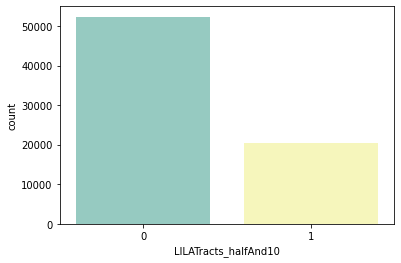

In [ ]:
sns.countplot(x = 'LILATracts_halfAnd10', data = df, palette = 'Set3' )

In [ ]:
var_0 = df[df['LILATracts_halfAnd10'] == 0]
var_1 = df[df['LILATracts_halfAnd10'] == 1]

print(var_0.shape, var_1.shape)

(52308, 72) (20556, 72)


In [ ]:
ros = RandomOverSampler(sampling_strategy = 'minority')
x_sam, y_sam = ros.fit_resample(x, y)

print(x_sam.shape, y_sam.shape)

(104616, 71) (104616,)


In [ ]:
X = pd.DataFrame(x_sam)
Y = pd.DataFrame(y_sam)
Y.values.ravel()

#Check the difference between dataset size between oversampling and after

print('Original dataset {}'. format(Counter(y)))
print('Resampled dataset{}'. format(Counter(y_sam)))

Original dataset Counter({0: 52308, 1: 20556})
Resampled datasetCounter({0: 52308, 1: 52308})


#### Splitting data into training, validation and testing sets

In [ ]:
#Split into Train, Validation, and Test Sets
train_size=0.8

#First split training data from the rest of the data
X_train, X_rest, y_train, y_rest = train_test_split(X, Y, train_size=0.8, random_state=56)

#Then split the rest of the data into test and validation
test_size = 0.5
X_val, X_test, y_val, y_test = train_test_split(X_rest,y_rest, test_size=0.5, random_state=35)


#### Normalizing the data

In [ ]:
mms = MinMaxScaler()

X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

# Random Forest

In [ ]:
#Train base model
base_model = RandomForestClassifier()
base_model.fit(X_train, y_train)
base_model.score(X_rest, y_rest)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.9768686675587842

In [ ]:
y_predicted = base_model.predict(X_test)
cm = confusion_matrix(y_test, y_predicted)
cm

array([[5245,   38],
       [  29, 5150]])

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 150, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 4)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 12, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 43, 76, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10, 12, 15],
 'n_estimators': [20, 52, 85, 117, 150]}


In [ ]:
# Use the random grid to search for best hyperparameters
rfm = RandomForestClassifier()
tuned_rfm = RandomizedSearchCV(estimator = rfm, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs=-1)
# Fit the random search model
tuned_rfm.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 43, 76, 110, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10, 12, 15],
                                        'n_estimators': [20, 52, 85, 117, 150]},
                   random_state=42, verbose=2)

In [ ]:
print(tuned_rfm.best_params_)
print(tuned_rfm.score(X_rest, y_rest))

{'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 110, 'bootstrap': False}


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.9761995794303192


In [ ]:
#Convert trails from RandomizedSearchCV into an array
random_param = tuned_rfm.cv_results_['params']
test_sets = []
for x in random_param:
    items = x.items()
    tolist = list(items)
    temp = []
    for y in tolist:
        temp.append(y[1])
    test_sets.append(temp)

In [ ]:
scores = tuned_rfm.cv_results_['mean_test_score']
scores = scores.reshape((100,1))
test_sets = np.append(test_sets, scores, axis = 1)

In [ ]:
plt.scatter(test_sets[:, 0], scores)
plt.show()

In [ ]:
f1score = f1_score(y_rest, y_pred, average=None)
rfm_probs = tuned_rfm.predict_proba(X_rest)[:, 1]
roc_value = roc_auc_score(y_rest, rfm_probs)

print(f1score)
print(roc_value)

In [ ]:
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(base_model, X_rest, y_rest, ax=ax, alpha=0.8)
plt.show()

In [ ]:
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(tuned_rfm, X_rest, y_rest, ax=ax, alpha=0.8)
plt.show()

# XGBoost

In [ ]:
evaluation = [(X_train, y_train), (X_val, y_val)]

Initialize XGBoost Classifier

In [ ]:
xgb_classifier = XGBClassifier(eval_metric='logloss', objective="binary:logistic", early_stopping_rounds = 5, n_estimators=10)
xgb_classifier.fit(X_train, y_train, verbose=True, eval_set=evaluation)

[0]	validation_0-logloss:0.604072	validation_1-logloss:0.604526
[1]	validation_0-logloss:0.531184	validation_1-logloss:0.531889
[2]	validation_0-logloss:0.471041	validation_1-logloss:0.471443
[3]	validation_0-logloss:0.419752	validation_1-logloss:0.420273
[4]	validation_0-logloss:0.375964	validation_1-logloss:0.376607
[5]	validation_0-logloss:0.338133	validation_1-logloss:0.339039
[6]	validation_0-logloss:0.306031	validation_1-logloss:0.30638
[7]	validation_0-logloss:0.277419	validation_1-logloss:0.277914
[8]	validation_0-logloss:0.252097	validation_1-logloss:0.253022
[9]	validation_0-logloss:0.23019	validation_1-logloss:0.23106
[10]	validation_0-logloss:0.210919	validation_1-logloss:0.21152
[11]	validation_0-logloss:0.193545	validation_1-logloss:0.194334
[12]	validation_0-logloss:0.178353	validation_1-logloss:0.179041
[13]	validation_0-logloss:0.164879	validation_1-logloss:0.165449
[14]	validation_0-logloss:0.152584	validation_1-logloss:0.153356
[15]	validation_0-logloss:0.141928	vali

XGBClassifier(eval_metric='logloss', n_estimators=50)

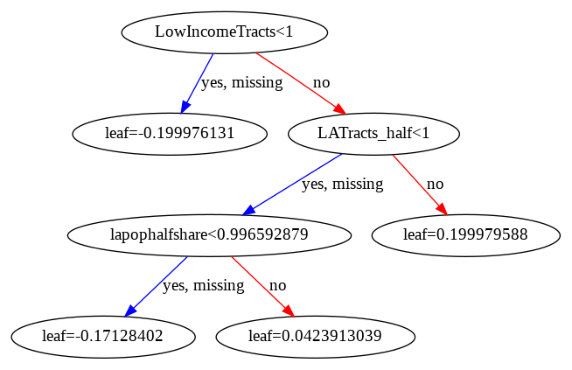

In [ ]:
xgb.plot_tree(xgb_classifier)
fig = plt.gcf()
fig.set_size_inches(10, 9)

In [ ]:
y_pred_train = xgb_classifier.predict(X_train)
y_pred_test = xgb_classifier.predict(X_test)
y_pred_val = xgb_classifier.predict(X_val)

Hyperparameter Tuning

In [ ]:
params = {
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(50, 100), # default 100
    "subsample": uniform(0.4, 0.8)
}

search_params = RandomizedSearchCV(xgb_classifier, param_distributions=params,n_iter=50, 
                            cv=3, verbose=1, n_jobs=1, return_train_score=True)
tune = True
if tune:
  search_params.fit(X_train, y_train, eval_set=evaluation, verbose = 0)

report_best_scores(search_params.cv_results_, 1)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
39 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py", line 732, in fit
    callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/training.py", line 216, in train
    xgb_model=xgb_model, callbacks=callbacks)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/training.py", line 

Model with rank: 1
Mean validation score: 0.987 (std: 0.001)
Parameters: {'gamma': 0.31192212490557614, 'learning_rate': 0.18523268743826385, 'max_depth': 5, 'n_estimators': 90, 'subsample': 0.6089075031747635}



Validation Loss Plotting

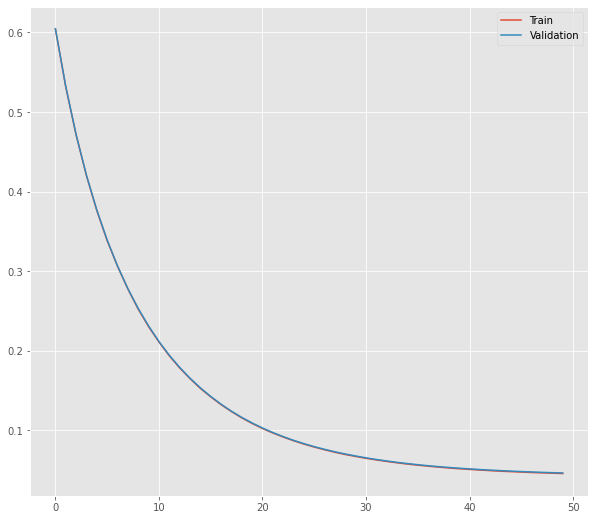

In [ ]:
results = xgb_classifier.evals_result()
plt.plot(results['validation_0']['logloss'], label='Train')
plt.plot(results['validation_1']['logloss'], label='Validation')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(10, 9)
plt.show()

Feature Importance

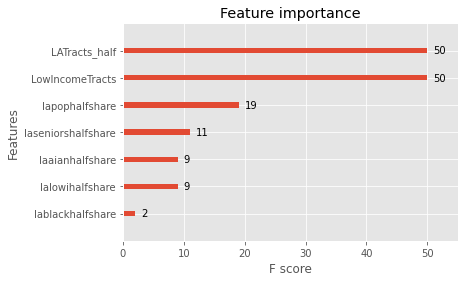

In [ ]:
plot_importance(xgb_classifier, max_num_features=len(x_set.columns) - 53)
plt.rcParams["figure.figsize"] = (8, 7)
plt.show()

Prediction

In [ ]:
f1score = f1_score(y_test, y_pred_test, average=None)
rf_probs = xgb_classifier.predict_proba(X_test)[:, 1]
roc_value = roc_auc_score(y_test, rf_probs)

print(f1score)
print(roc_value)

result_df = pd.DataFrame({
     'Response': ['Yes', 'No'],
     'Train':[sum(y_train == 1), sum(y_train == 0)],
     'Validation':[sum(y_test == 1), sum(y_test == 0)],
     'Test':[sum(y_val == 1), sum(y_val == 0)]})

prediction_df = pd.DataFrame({
     'Response': ['Yes', 'No'],
     'Train':[sum(y_pred_train == 1), sum(y_pred_train == 0)],
     'Validation':[sum(y_pred_test == 1), sum(y_pred_test == 0)],
     'Test':[sum(y_pred_val == 1), sum(y_pred_val == 0)]})

print('Dataset')
blankIndex=[''] * len(result_df)
result_df.index=blankIndex
display(result_df)

print('Prediction')
blankIndex=[''] * len(prediction_df)
prediction_df.index=blankIndex
display(prediction_df)

[0.97750898 0.97698704]
0.9986349925734604
Dataset


,Response,Train,Validation,Test
,Yes,41949,5179,5180
,No,41743,5283,5282


Prediction


,Response,Train,Validation,Test
,Yes,41910,5163,5204
,No,41782,5299,5258


<h3> Accuracy and Classification Error </h3>

In [ ]:
error = accuracy_score(y_train, y_pred_train)
print('XGBoost')
print('---------------------------------------')
print('Train Classification Accuracy')
print('---------------------------------------')
print('\tDataset: ', error*100)
print('---------------------------------------')
print('Train Classification Error')
print('---------------------------------------')
print('\tDataset: ', (1-error)*100,'%')
print('---------------------------------------')
error = accuracy_score(y_test, y_pred_test)
print('---------------------------------------')
print('Test Classification Accuracy')
print('---------------------------------------')
print('\tDataset: ', error*100, '%')
print('---------------------------------------')
print('Test Classification Error')
print('---------------------------------------')
print('\tDataset: ', (1-error)*100,'%')
print('---------------------------------------')
error = accuracy_score(y_val, y_pred_val)
print('---------------------------------------')
print('Validation Classification Accuracy')
print('---------------------------------------')
print('\tDataset: ', error*100, '%')
print('---------------------------------------')
print('Test Classification Error')
print('---------------------------------------')
print('\tDataset: ', (1-error)*100,'%')
print('---------------------------------------')

XGBoost
---------------------------------------
Train Classification Accuracy
---------------------------------------
	Dataset:  97.94365052812695
---------------------------------------
Train Classification Error
---------------------------------------
	Dataset:  2.0563494718730535 %
---------------------------------------
---------------------------------------
Test Classification Accuracy
---------------------------------------
	Dataset:  97.72510036321927 %
---------------------------------------
Test Classification Error
---------------------------------------
	Dataset:  2.274899636780725 %
---------------------------------------
---------------------------------------
Validation Classification Accuracy
---------------------------------------
	Dataset:  97.87803479258268 %
---------------------------------------
Test Classification Error
---------------------------------------
	Dataset:  2.12196520741732 %
---------------------------------------


In [ ]:
xgb_classifier_tune = XGBClassifier(eval_metric='logloss', objective="binary:logistic", 
            n_estimators=10, colsample_bytree = 0.9398183878369726, gamma = 0.21039837825483954,
                              learning_rate = 0.2092801969367922, max_depth = 5, subsample = 0.8976324718655304)
xgb_classifier_tune.fit(X_train, y_train, verbose=True, eval_set=evaluation)
y_pred_train = xgb_classifier_tune.predict(X_train)
y_pred_test = xgb_classifier_tune.predict(X_test)
y_pred_val = xgb_classifier_tune.predict(X_val)
error = accuracy_score(y_train, y_pred_train)
print('XGBoost')
print('---------------------------------------')
print('Train Classification Accuracy')
print('---------------------------------------')
print('\tDataset: ', error*100)
print('---------------------------------------')
print('Train Classification Error')
print('---------------------------------------')
print('\tDataset: ', (1-error)*100,'%')
print('---------------------------------------')
error = accuracy_score(y_test, y_pred_test)
print('---------------------------------------')
print('Test Classification Accuracy')
print('---------------------------------------')
print('\tDataset: ', error*100, '%')
print('---------------------------------------')
print('Test Classification Error')
print('---------------------------------------')
print('\tDataset: ', (1-error)*100,'%')
print('---------------------------------------')
error = accuracy_score(y_val, y_pred_val)
print('---------------------------------------')
print('Validation Classification Accuracy')
print('---------------------------------------')
print('\tDataset: ', error*100, '%')
print('---------------------------------------')
print('Test Classification Error')
print('---------------------------------------')
print('\tDataset: ', (1-error)*100,'%')
print('---------------------------------------')

[0]	validation_0-logloss:0.515964	validation_1-logloss:0.516782
[1]	validation_0-logloss:0.428473	validation_1-logloss:0.429121
[2]	validation_0-logloss:0.337309	validation_1-logloss:0.338136
[3]	validation_0-logloss:0.27101	validation_1-logloss:0.272044
[4]	validation_0-logloss:0.221342	validation_1-logloss:0.222604
[5]	validation_0-logloss:0.183392	validation_1-logloss:0.18465
[6]	validation_0-logloss:0.153902	validation_1-logloss:0.155396
[7]	validation_0-logloss:0.130784	validation_1-logloss:0.132196
[8]	validation_0-logloss:0.112543	validation_1-logloss:0.114034
[9]	validation_0-logloss:0.09797	validation_1-logloss:0.099691
XGBoost
---------------------------------------
Train Classification Accuracy
---------------------------------------
	Dataset:  98.03445968551355
---------------------------------------
Train Classification Error
---------------------------------------
	Dataset:  1.965540314486447 %
---------------------------------------
--------------------------------------

# FeedForward Neural Network

#### Converting numpy to tensor values

In [ ]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_test = torch.from_numpy(X_test).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([83692, 71]) torch.Size([83692])
torch.Size([10462, 71]) torch.Size([10462])


#### Building Neural Network Model

In [ ]:
class Net(nn.Module):
    def __init__(self, n_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        return torch.sigmoid(self.fc4(x))
    
net = Net(X_train.shape[1])

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
net = net.to(device)
criterion = criterion.to(device)

In [ ]:
#Accuracy
def calculate_accuracy(y_true, y_pred):
    pred = y_pred.ge(.5).view(-1)
    return (y_true == pred).sum().float() / len(y_true)

In [ ]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)

tr_loss = []
tst_loss = []

for epoch in range(1000):
    y_pred = net(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    tr_loss.append(train_loss)
    
    if epoch % 100 == 0:
        
        train_acc = calculate_accuracy(y_train, y_pred)
        
        y_test_pred = net(X_test)
        y_test_pred = torch.squeeze(y_test_pred)
        test_loss = criterion(y_test_pred, y_test)
        tst_loss.append(test_loss)
        
        test_acc = calculate_accuracy(y_test, y_test_pred)
        
        print(
            f'''epoch {epoch}
            Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
            Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
            ''')
        
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

epoch 0
            Train set - loss: 0.692, accuracy: 0.638
            Test  set - loss: 0.692, accuracy: 0.642
            
epoch 100
            Train set - loss: 0.042, accuracy: 0.979
            Test  set - loss: 0.046, accuracy: 0.977
            
epoch 200
            Train set - loss: 0.037, accuracy: 0.982
            Test  set - loss: 0.04, accuracy: 0.98
            
epoch 300
            Train set - loss: 0.035, accuracy: 0.983
            Test  set - loss: 0.038, accuracy: 0.981
            
epoch 400
            Train set - loss: 0.034, accuracy: 0.984
            Test  set - loss: 0.038, accuracy: 0.982
            
epoch 500
            Train set - loss: 0.033, accuracy: 0.985
            Test  set - loss: 0.037, accuracy: 0.982
            
epoch 600
            Train set - loss: 0.032, accuracy: 0.985
            Test  set - loss: 0.037, accuracy: 0.982
            
epoch 700
            Train set - loss: 0.031, accuracy: 0.986
            Test  set - loss: 0.037, a

##### Plotting errors 

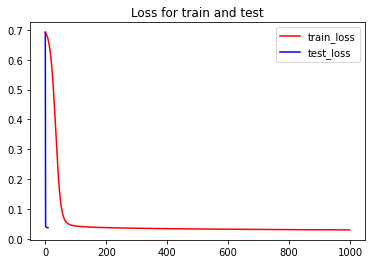

In [ ]:
with torch.no_grad():
    a = tr_loss
    b = tst_loss
    
    plt.plot(a, color ='red', label = 'train_loss')
    plt.plot(b, color='blue', label = 'test_loss')
    
    plt.title('Loss for train and test')
    plt.legend()
    plt.show()

In [ ]:
#Saving the model

MODEL_PATH = 'model.pth'
torch.save(net, MODEL_PATH)

net = torch.load(MODEL_PATH)

In [ ]:
from sklearn.metrics import classification_report
classes = ['1', '0']

y_pred = net(X_test)

y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

           1       0.98      0.98      0.98      5283
           0       0.98      0.98      0.98      5179

    accuracy                           0.98     10462
   macro avg       0.98      0.98      0.98     10462
weighted avg       0.98      0.98      0.98     10462



Text(0.5, 15.0, 'Predicted label')

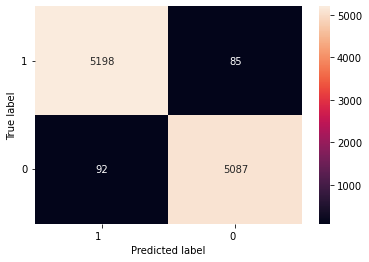

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')